In [1]:
import pandas as pd
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [2]:
def reshape_dataset(dataframe,dupl_list=['x','y','dt_placement'],group_list=['x','y','dt_placement'],mosq_col='culex.spp'):
    """Removes the duplicates rows and aggragates observations needed
    
    Parameters
    ----------
    dataframe: Dataframe
        Dataframe to be transformed
    
    dupl_list : list
        A list with the names of the columns for removing the duplicates upon them (default=['x','y','dt_placement'])
        
    group_list : list
        A list with the names of the columns for grouping the duplicates upon them (default=['x','y','dt_placement'])
    
    mosq_col : str, optional
        The name of the column with the mosquito number (default = 'mosq_now')
        
    Returns
    ----------
    dataframe: Dataframe
        A transformed dataframe
        
    Raises
    ------    
    KeyError
        If column name(s) given not in index
    """
    
    if (mosq_col not in dataframe.columns):
        raise KeyError('Column(s) not in index')
    if len(dupl_list) != 0:
        for i in dupl_list:
            if i not in dataframe.columns:
                raise KeyError('Column(s) not in index')
    dataframe.drop_duplicates(subset=dupl_list+[mosq_col], keep='first',inplace=True)
    agg_dict = {mosq_col: lambda x: x.sum(min_count=1)}
    col = [e for e in dataframe.columns if e not in [mosq_col]+group_list]
    for i in col:
        agg_dict[i]= 'first'
    dataframe = dataframe.groupby(group_list).agg(agg_dict).reset_index()
    return dataframe

In [3]:
def validate_results(predictions_path, data_path, bounds, mosq_col, case, region = '', dupl_list = ['x','y','dt_placement'], period=8):
    """Checks the accuracy of the predictions of the previous month.
    
     Parameters
    --------
    predictions_path : str
        A path to the file containing the predictions of a month
        
    data_path : str
        A path dataframe containing the dates and the actual classes on each date
        
    period : int, optional
        The period around a prediction that is acceptable to check for error (default = 8)
    """
    month = {1:'Janauary',
        2:'February',
        3:'March',
        4:'April',
        5:'May',
        6:'June',
        7:'July',
        8:'August',
        9:'September',
        10:'October',
        11:'November',
        12:'December'}
    data = pd.read_csv(data_path)
    if region != '':
        data = data[data.nuts2_name == region]
        data = data.reset_index(drop=True)
    data['dt_placement'] = pd.to_datetime(data['dt_placement'], format="%Y-%m-%d")
    data['x'] = round(data['x'], 6)
    data['y'] = round(data['y'], 6)
    data = reshape_dataset(data,dupl_list=dupl_list,mosq_col=mosq_col)
    
    x = os.listdir(predictions_path)
    f = []
    for e in x:
        if '2022' in e:
            f.append(predictions_path+e)

    predictions = pd.DataFrame()
    for i in f:
        predictions = pd.concat([predictions,pd.read_csv(i)])
    predictions = predictions.sort_values(by=['dt_placement']).reset_index(drop=True)
    predictions['dt_placement'] = pd.to_datetime(predictions['dt_placement'], format="%Y-%m-%d")
    predictions['dt_prediction'] = pd.to_datetime(predictions['dt_prediction'], format="%Y-%m-%d")

    actual = []
    date_l = []
    classes = list(range(len(bounds)-1))
    bins,bounds = pd.cut(data.loc[:,mosq_col],bins=bounds,retbins=True,labels=classes)
    data.loc[:,'mosq_bins'] = bins

    for i in range(len(predictions)):
        data1 = data.loc[(data['x'] == predictions.loc[i,'x']) & (data['y'] == predictions.loc[i,'y'])]
        data1 = data1.reset_index(drop=True)        
        date =  predictions.loc[i,'dt_prediction']
        diff = (data1.dt_placement - date).dt.days
        indexmin = diff.abs().idxmin()
        y = data1.loc[indexmin,'mosq_bins']
        d = diff[indexmin]
        while np.isnan(y) and (len(diff) !=0):
            diff = diff.drop(indexmin)
            if len(diff) !=0:
                indexmin = diff.abs().idxmin()
                y = data1.loc[indexmin,'mosq_bins']
                d = diff[indexmin]
        date_l.append(d)
        actual.append(y)
    predictions.loc[:,'actual'] = actual
    predictions.loc[:,'time_diff'] = date_l
#     predictions.to_csv('kk.csv',index=False)
    predictions = predictions.loc[np.abs(predictions['time_diff'])<period]
   
    if len(predictions) != 0:
        total_error = []
        total_percentage = []
        names = ['Overall MAE', 'MAE with entomological:','MAE without entomological:']
        x = predictions['predictions']-predictions['actual']
        print('Mean time difference in days:',predictions['time_diff'].mean())
        print('-------------------')
        print('Overall MAE:',np.abs(x).mean())
        print('Overall % error < 3:', np.round((np.abs(x) < 3.5).mean()*100,2))
        total_error.append(np.abs(x).mean())
        total_percentage.append(np.round((np.abs(x) < 3.5).mean()*100,2))
        print('-------------------')
        ent = predictions.loc[predictions['entomological_features']==True]
        if len(ent) != 0:
            x = ent['predictions']-ent['actual']
            print('MAE with entomological:',np.abs(x).mean())
            print('% error < 3 with entomological:', np.round((np.abs(x) < 3.5).mean()*100,2))
            total_error.append(np.abs(x).mean())
            total_percentage.append(np.round((np.abs(x) < 3.5).mean()*100,2))
            print('-------------------')
        else:
            total_error.append(np.nan)
            total_percentage.append(np.nan)
        ent = predictions.loc[predictions['entomological_features']==False]
        if len(ent) != 0:    
            x = ent['predictions']-ent['actual']
            print('MAE without entomological:',np.abs(x).mean())
            print('% error < 3 without entomological:', np.round((np.abs(x) < 3.5).mean()*100,2))
            total_error.append(np.abs(x).mean())
            total_percentage.append(np.round((np.abs(x) < 3.5).mean()*100,2))
            print('-------------------')
        else:
            total_error.append(np.nan)
            total_percentage.append(np.nan)
            
        print('number of observations:',len(predictions))
        
        
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        barlist = ax.bar(names,total_error,color='blue')
        for i, v in enumerate(total_error):
            ax.text(i, v, str('%.2f'%(v)),rotation=30)
        plt.ylabel('MAE')
        plt.title(case)
        fig.savefig(case+' overall_mae.png',bbox_inches='tight')
        plt.show()
        
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        barlist = ax.bar(names,total_percentage,color='blue')
        for i, v in enumerate(total_percentage):
            ax.text(i, v, str('%.2f'%(v)+'%'),rotation=30)
        plt.ylabel('% of error < 3')
        plt.title(case)
        fig.savefig(case+' overall_percentage.png',bbox_inches='tight')
        plt.show()
        
        months = predictions['dt_prediction'].dt.month.unique()
        months.sort()
        error_list = []
        error_list_ent = []
        error_list_env = []
        for x in months:
            data1 = predictions.loc[predictions['dt_prediction'].dt.month==x]
            print('month',x,':',len(data1))
            error = data1['predictions']-data1['actual']
            print('month '+ str(x) +':', np.abs(error).mean())
            error_list.append(np.abs(error).mean())
            ent = data1.loc[data1['entomological_features']==True]
            if len(ent) != 0:
                error = ent['predictions']-ent['actual']
                error_list_ent.append(np.abs(error).mean())
            else:
                error_list_ent.append(np.nan)
            ent = data1.loc[data1['entomological_features']==False]
            if len(ent) != 0:
                error = ent['predictions']-ent['actual']
                error_list_env.append(np.abs(error).mean())
            else:
                error_list_env.append(np.nan)
                
        total = []
        for i in range(len(months)):
            total.append([error_list[i],error_list_ent[i],error_list_env[i]])
                
        months = [month.get(x) for x in months]
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        barlist = ax.bar(months,error_list,color='blue')
        for i, v in enumerate(error_list):
            ax.text(i, v, str('%.2f'%(v)),rotation=30)
        plt.xlabel('month')
        plt.ylabel('MAE')
        plt.title(case)
        fig.savefig(case +' months.png',bbox_inches='tight')
        plt.show()
        
#         groups = total
#         group_labels = months

        # Convert data to pandas DataFrame.
        df = pd.DataFrame(total, index=months)
        df.columns = ['total',"entomological","environmental"]
        
        ax = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=case)
        i = 0
        for p in ax.patches:
            row = i%(len(df))
            column = i//(len(df))
            if not math.isnan(df.iloc[row,column]):
                ax.annotate('%.2f'%(p.get_height()), (p.get_x() * 1.035, p.get_height() * 1.005),rotation=30)
            i += 1
            
        fig = ax.get_figure()
        fig.savefig(case+' overall_months.png')

            
#         fig = df.plot(kind='bar',figsize=(10,8),width=0.8, ylabel="MAE",title=case).get_fig() 
#         fig.savefig(predictions_path+'overall_mae_month.png')
        
#         plt.scatter(np.abs(predictions['time_diff']),np.abs(predictions['predictions']-predictions['actual']))
#         plt.title('Absolute Error with respect to Time Difference')
#         plt.ylabel('Absolute error')
#         plt.xlabel('Time Difference (Days)')
#         m, b = np.polyfit(np.abs(predictions['time_diff']),np.abs(predictions['predictions']-predictions['actual']), 1)
#         plt.plot(np.abs(predictions['time_diff']), m*np.abs(predictions['time_diff']) + b,'r',label='y={:.2f}x+{:.2f}'.format(m,b))
#         plt.legend()
#         plt.show()
    else:
        print('No predictions with difference less than %d days' % period)

C:\Users\irots\AppData\Local\Temp\ipykernel_20396\604679397.py:27: DtypeWarning: Columns (0,7,9,11,13,15,16,18,37,38,39,41,43,58) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


Mean time difference in days: 3.375
-------------------
Overall MAE: 3.1875
Overall % error < 3: 68.75
-------------------
MAE without entomological: 3.1875
% error < 3 without entomological: 68.75
-------------------
number of observations: 16


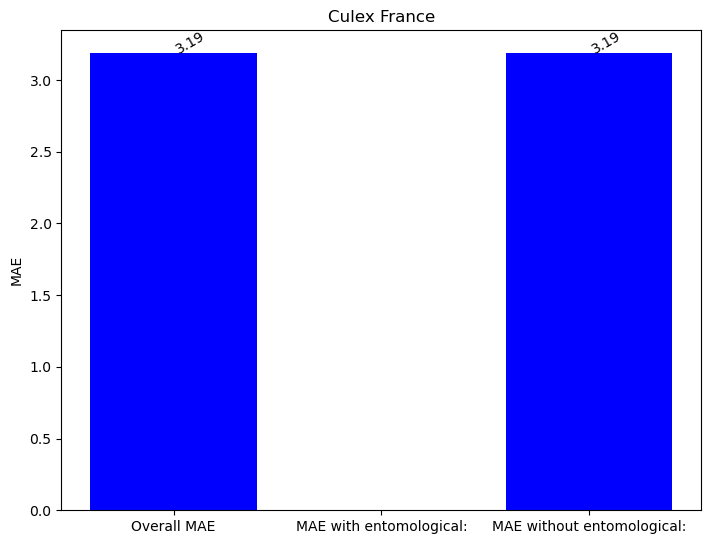

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


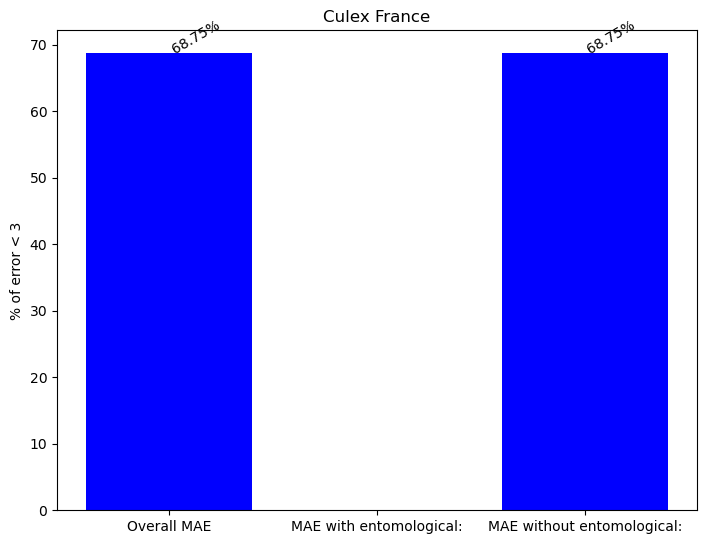

month 6 : 9
month 6: 2.6666666666666665
month 7 : 7
month 7: 3.857142857142857


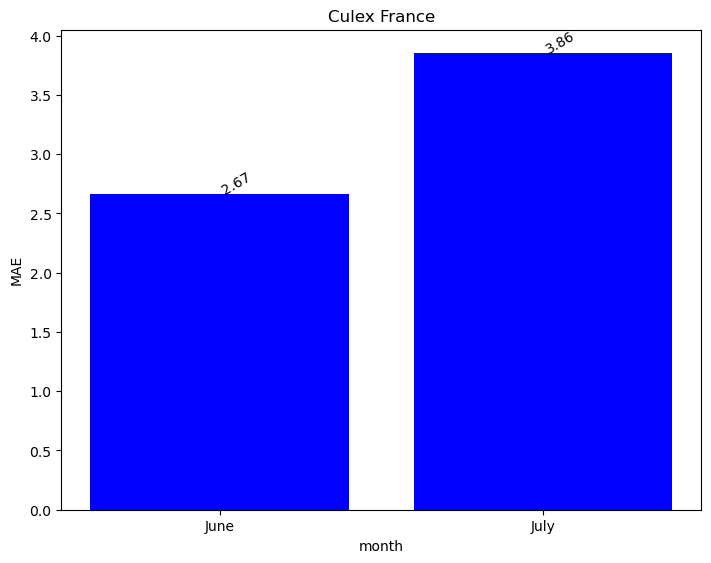

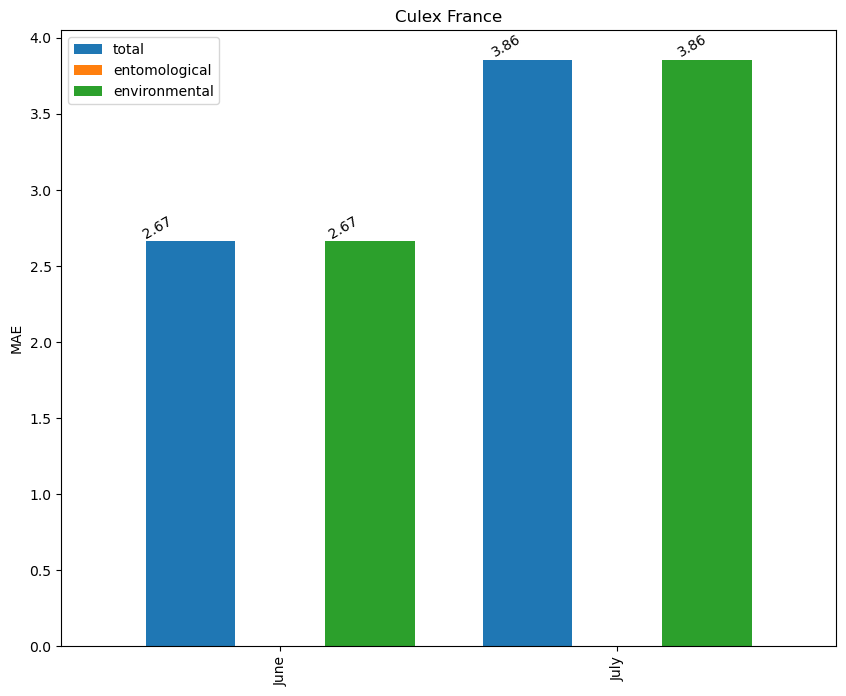

In [4]:
validate_results(predictions_path = '../predictions/France/Culex/',
                 data_path = '../../Datasets/France/Culex/FR_culex_2007_2022.csv',
                 bounds = [-1,   1.,  4.,  8.,  11., 16., 23., 30., 60., 206., np.inf],
                 mosq_col = 'culex.spp',case = 'Culex France', period = 10)

C:\Users\irots\AppData\Local\Temp\ipykernel_20396\604679397.py:27: DtypeWarning: Columns (7,9,10,11,12,13,14,15,16,17,18,22,37,38,39,41,43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


Mean time difference in days: 0.29694323144104806
-------------------
Overall MAE: 1.5327510917030567
Overall % error < 3: 90.83
-------------------
MAE with entomological: 1.25
% error < 3 with entomological: 93.55
-------------------
MAE without entomological: 1.8666666666666667
% error < 3 without entomological: 87.62
-------------------
number of observations: 229


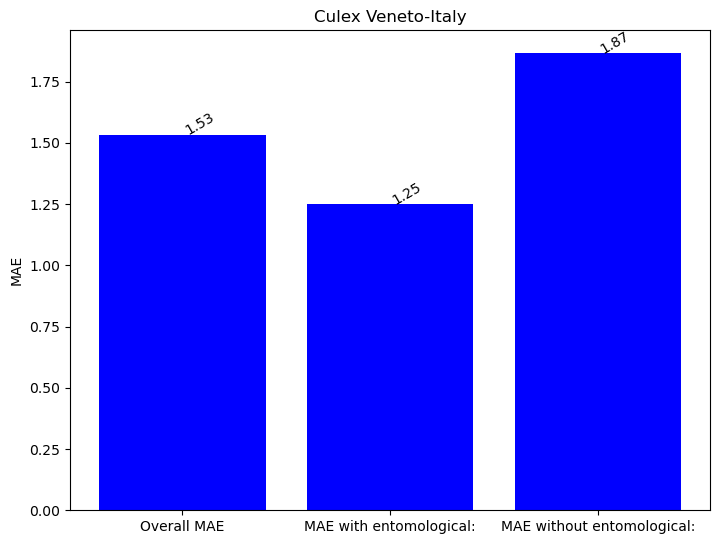

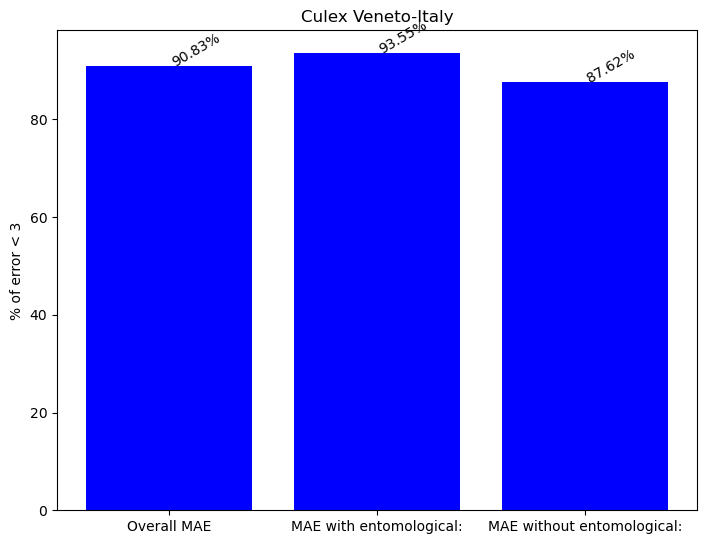

month 5 : 45
month 5: 1.8888888888888888
month 6 : 25
month 6: 1.24
month 7 : 21
month 7: 1.4761904761904763
month 8 : 99
month 8: 1.6464646464646464
month 9 : 39
month 9: 1.0512820512820513


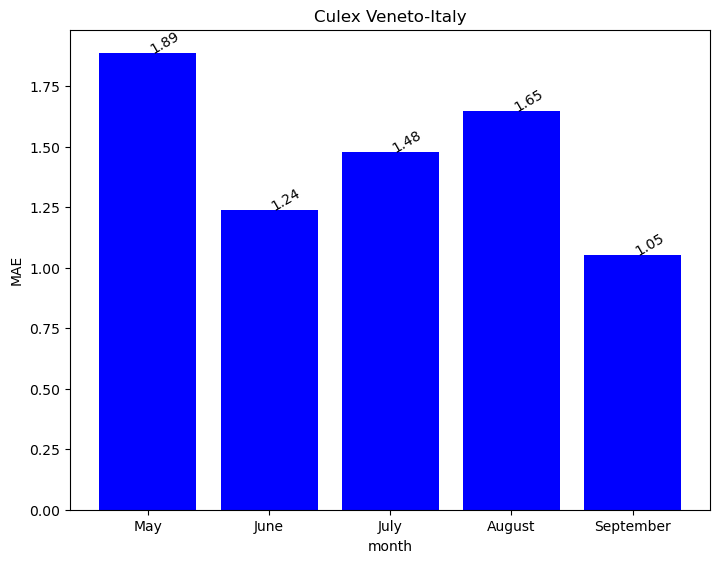

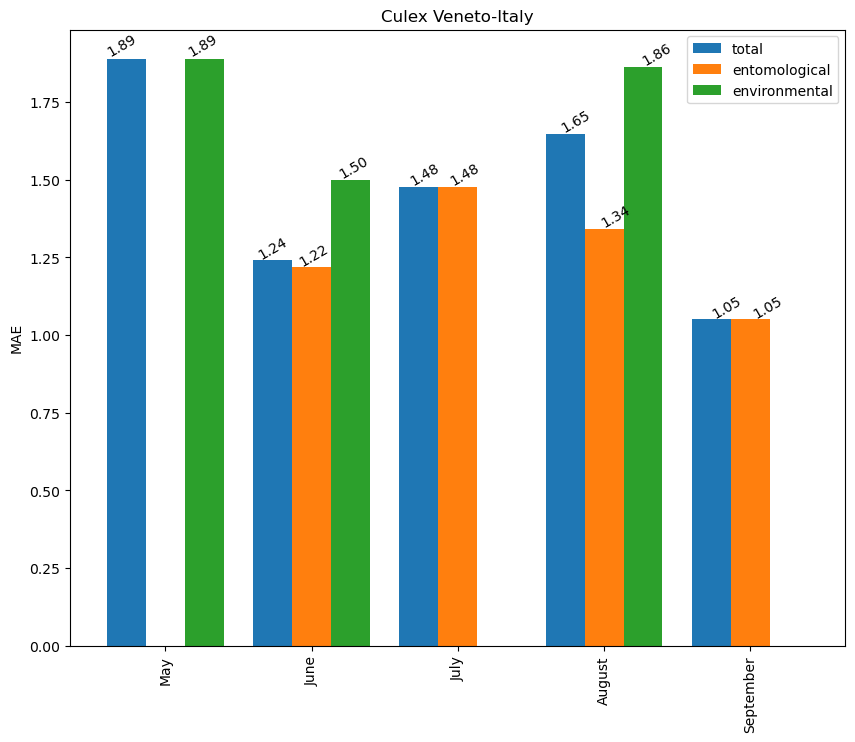

In [5]:
validate_results(predictions_path = '../predictions/Italy/Veneto/Culex/',
                 data_path = '../../Datasets/Italy/Veneto/Culex/IT_veneto_culex_2010_2022.csv',
                 bounds = [-1., 4., 9., 19., 34., 56., 93.4, 156., 268., 538.6, 7463.],
                 mosq_col = 'culex.spp',case = 'Culex Veneto-Italy', period = 10)

Mean time difference in days: -0.42857142857142855
-------------------
Overall MAE: 2.3333333333333335
Overall % error < 3: 69.84
-------------------
MAE with entomological: 0.4782608695652174
% error < 3 with entomological: 100.0
-------------------
MAE without entomological: 3.4
% error < 3 without entomological: 52.5
-------------------
number of observations: 63


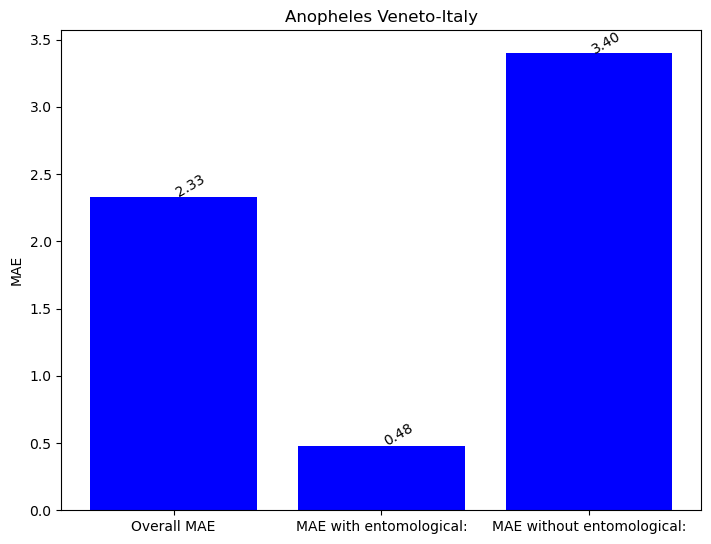

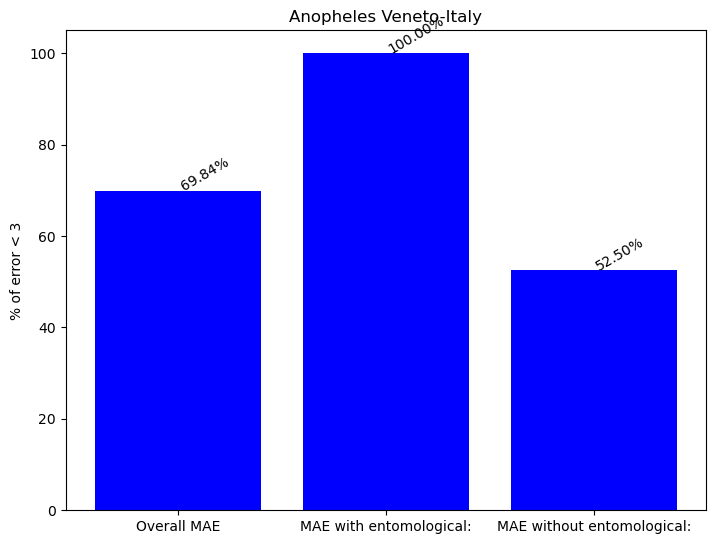

month 6 : 33
month 6: 3.6363636363636362
month 7 : 14
month 7: 0.9285714285714286
month 8 : 12
month 8: 1.0
month 9 : 2
month 9: 0.5
month 10 : 2
month 10: 0.5


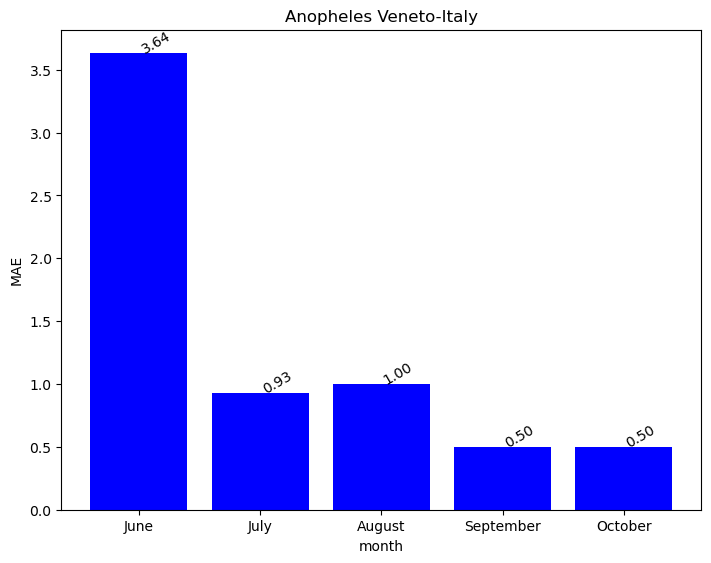

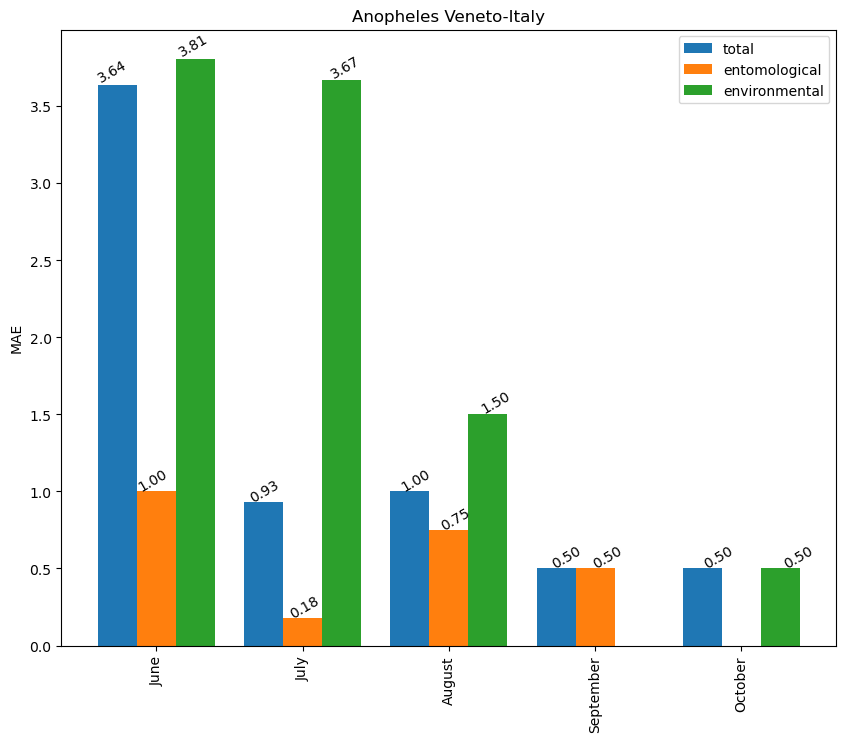

In [6]:
validate_results(predictions_path = '../predictions/Italy/Veneto/Anopheles/',
                 data_path = '../../Datasets/Italy/Veneto/Anopheles/IT_veneto_anopheles_2010_2022.csv',
                 bounds = [-1., 2., 16.4, 49., 99.8, 198.5, 319.4, 505.6, 780., 1300.3, 13398. ],
                 mosq_col = 'anopheles_total', case = 'Anopheles Veneto-Italy', period = 10)

Mean time difference in days: -3.59375
-------------------
Overall MAE: 2.0
Overall % error < 3: 83.33
-------------------
MAE with entomological: 2.0120481927710845
% error < 3 with entomological: 83.13
-------------------
MAE without entomological: 1.9230769230769231
% error < 3 without entomological: 84.62
-------------------
number of observations: 96


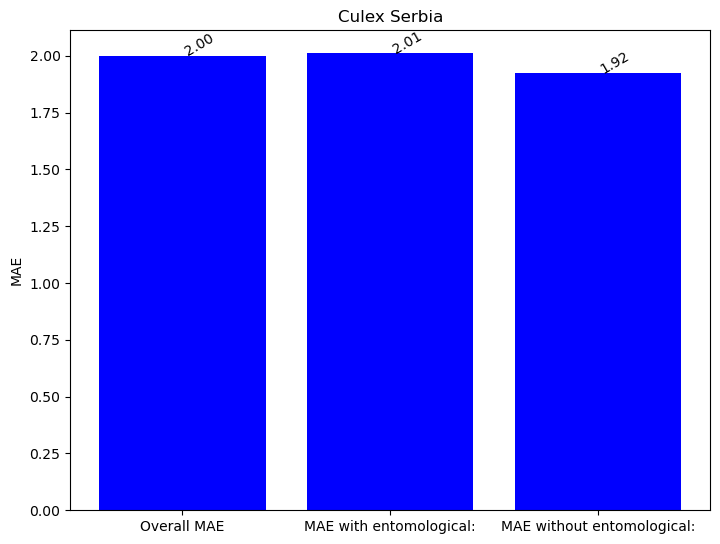

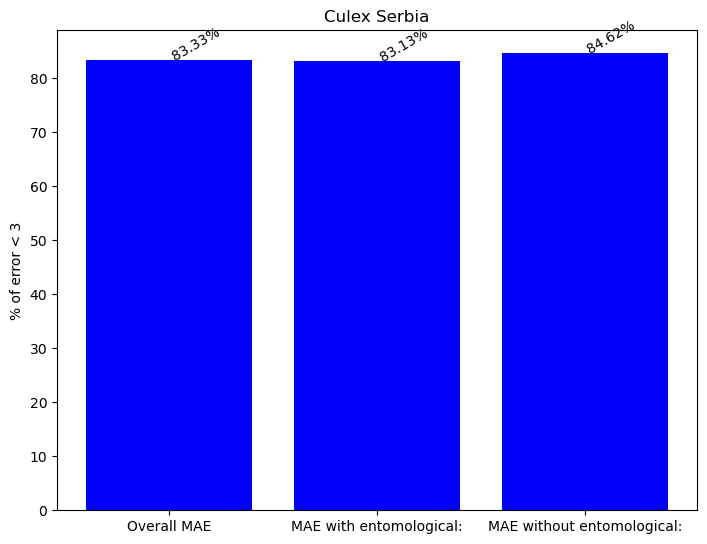

month 6 : 65
month 6: 2.2153846153846155
month 7 : 12
month 7: 2.0833333333333335
month 8 : 13
month 8: 1.2307692307692308
month 9 : 6
month 9: 1.1666666666666667


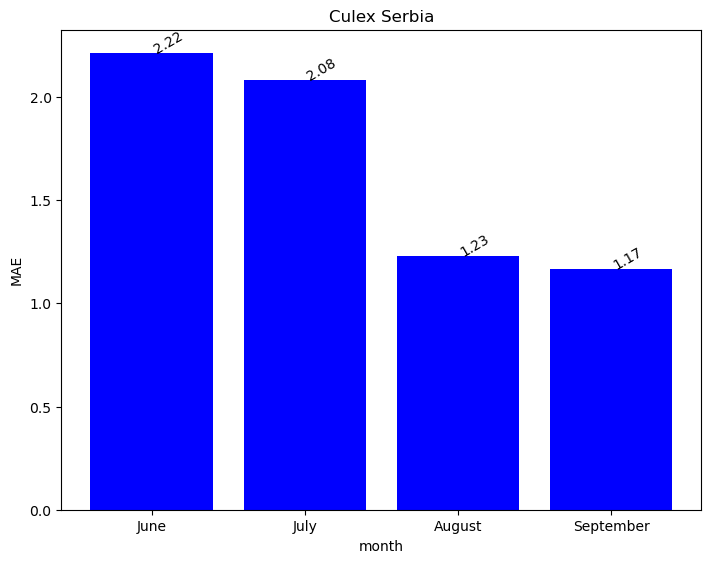

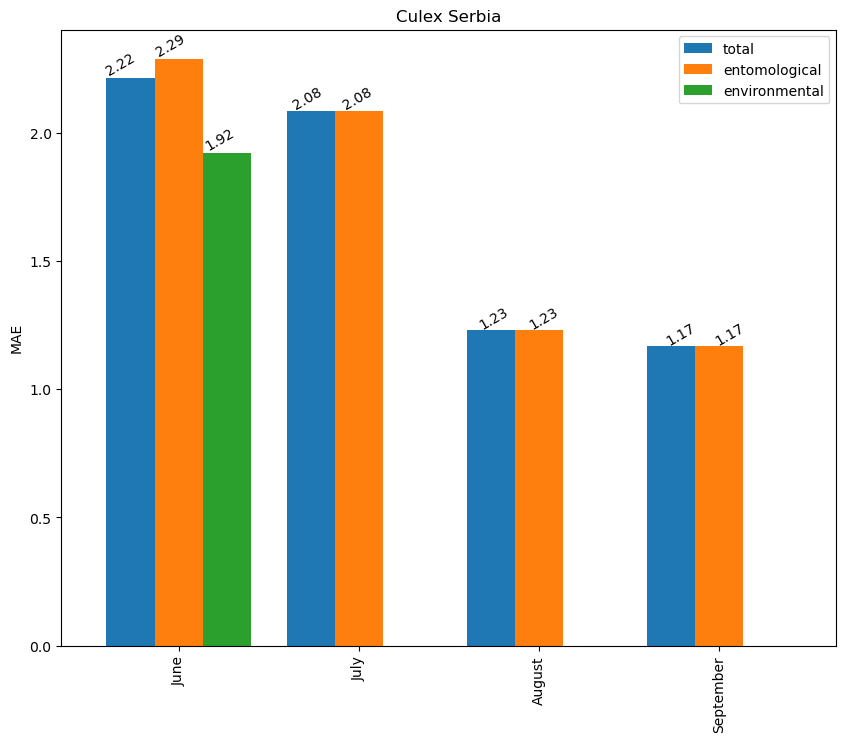

In [7]:
validate_results(predictions_path = '../predictions/Serbia/',
                 data_path = '../../Datasets/Serbia/Vojvodina/SRB_vojvodina_culex_2010_2022.csv',
                 bounds = [-1., 15., 38., 81., 144.6, 200., 256., 408., 638.4, 1136., 23248.],
                 mosq_col = 'culex.spp', case = 'Culex Serbia',period = 10)

Mean time difference in days: 0.8979591836734694
-------------------
Overall MAE: 1.280612244897959
Overall % error < 3: 92.35
-------------------
MAE with entomological: 1.1327433628318584
% error < 3 with entomological: 92.92
-------------------
MAE without entomological: 1.4819277108433735
% error < 3 without entomological: 91.57
-------------------
number of observations: 196


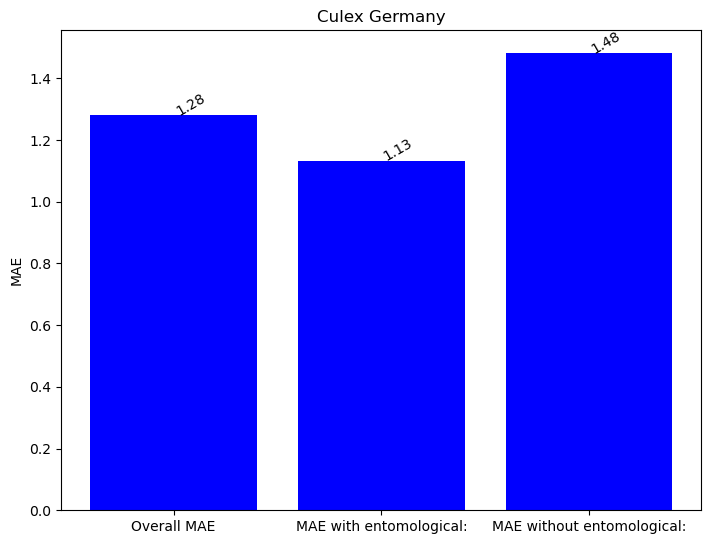

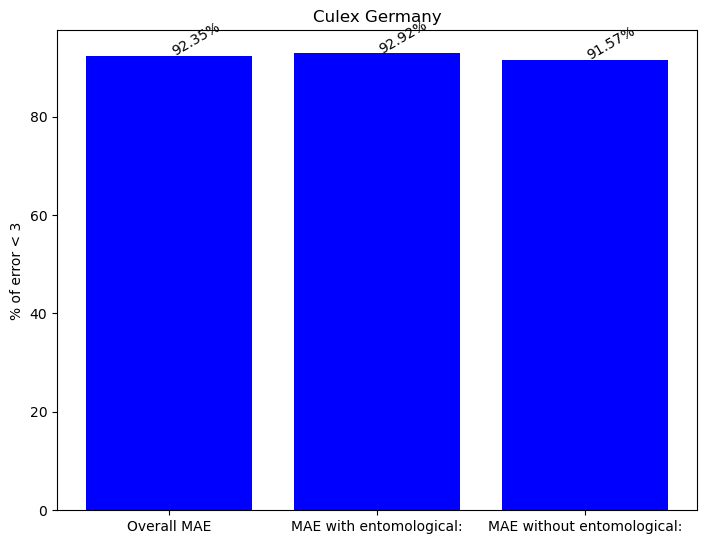

month 5 : 13
month 5: 0.7692307692307693
month 6 : 64
month 6: 2.265625
month 7 : 38
month 7: 1.394736842105263
month 8 : 38
month 8: 1.131578947368421
month 9 : 21
month 9: 0.0
month 10 : 22
month 10: 0.0


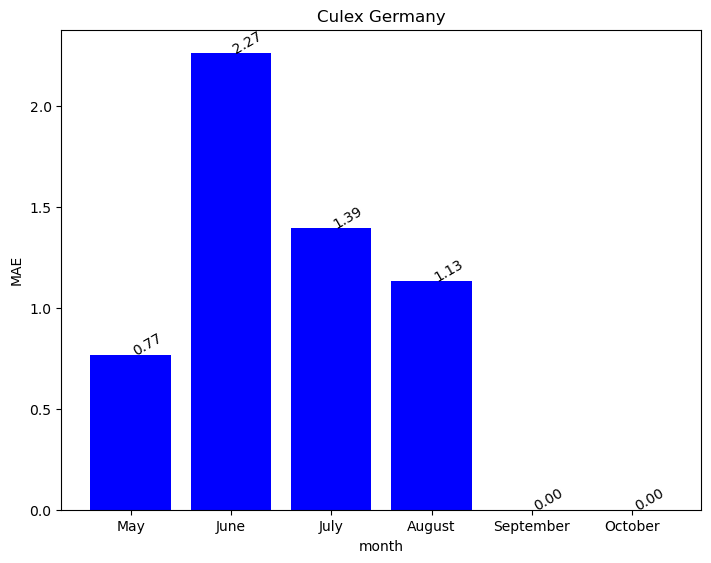

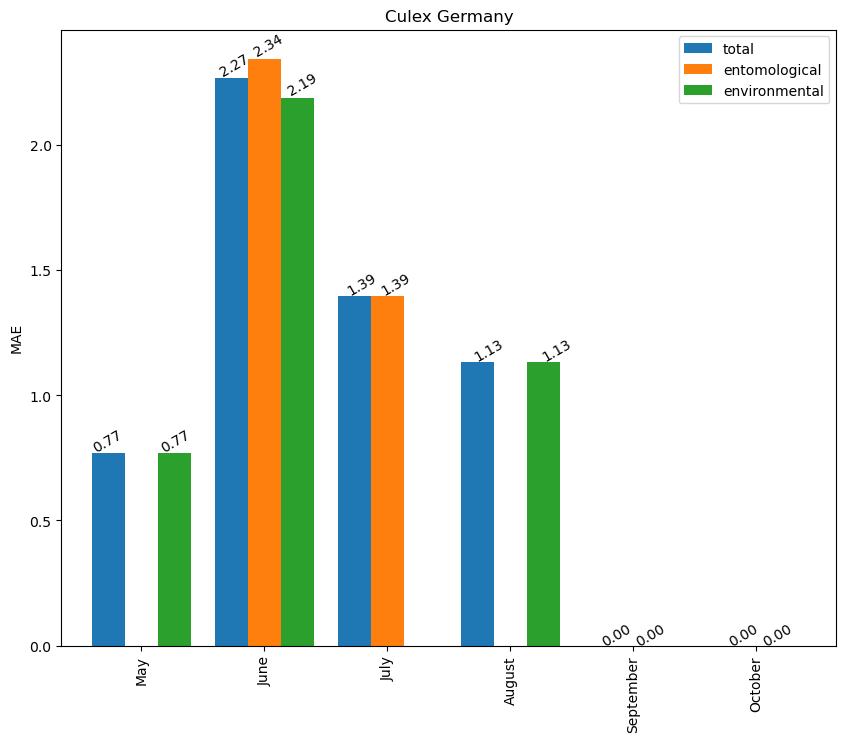

In [8]:
validate_results(predictions_path = '../predictions/Germany/',
                 data_path = '../../Datasets/Germany/GER_wuerttemberg_culex_2010_2022.csv',
                 bounds = [-1,   1.,  3.,  8.,  11., 16., 23., 37., 78., 206., np.inf],
                 mosq_col = 'culex.spp', case = 'Culex Germany', period = 10)

Mean time difference in days: -0.5774647887323944
-------------------
Overall MAE: 1.8309859154929577
Overall % error < 3: 87.32
-------------------
MAE with entomological: 1.6407185628742516
% error < 3 with entomological: 92.22
-------------------
MAE without entomological: 2.1025641025641026
% error < 3 without entomological: 80.34
-------------------
number of observations: 284


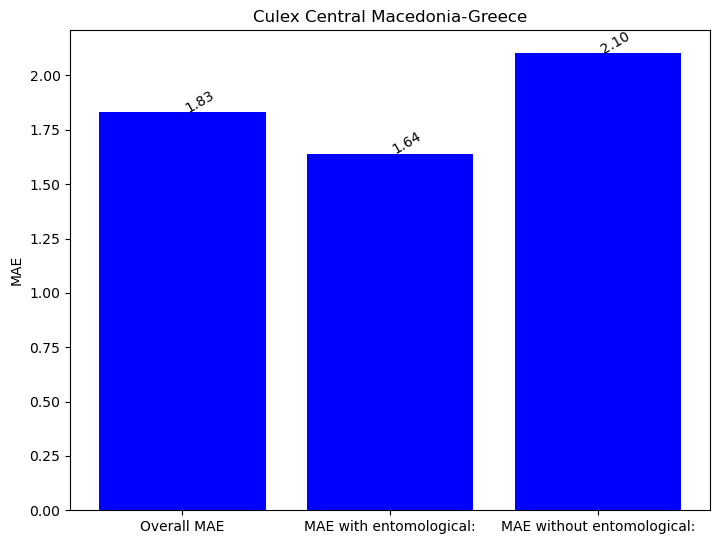

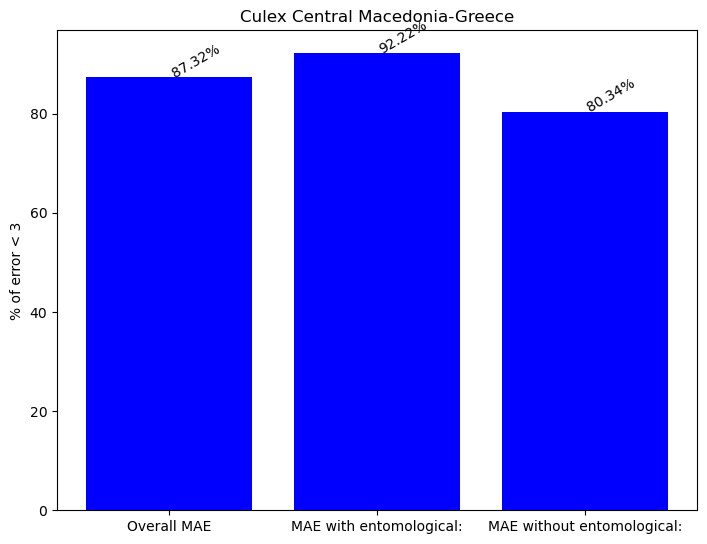

month 5 : 40
month 5: 2.45
month 6 : 129
month 6: 1.821705426356589
month 7 : 46
month 7: 1.391304347826087
month 8 : 69
month 8: 1.7826086956521738


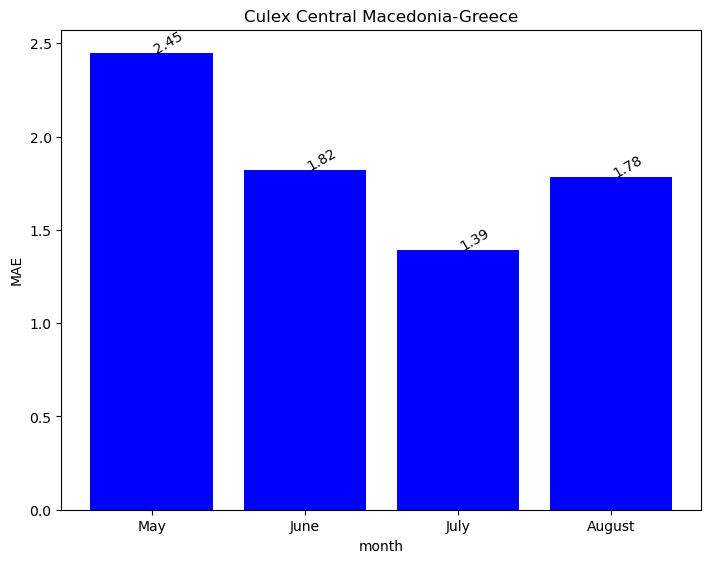

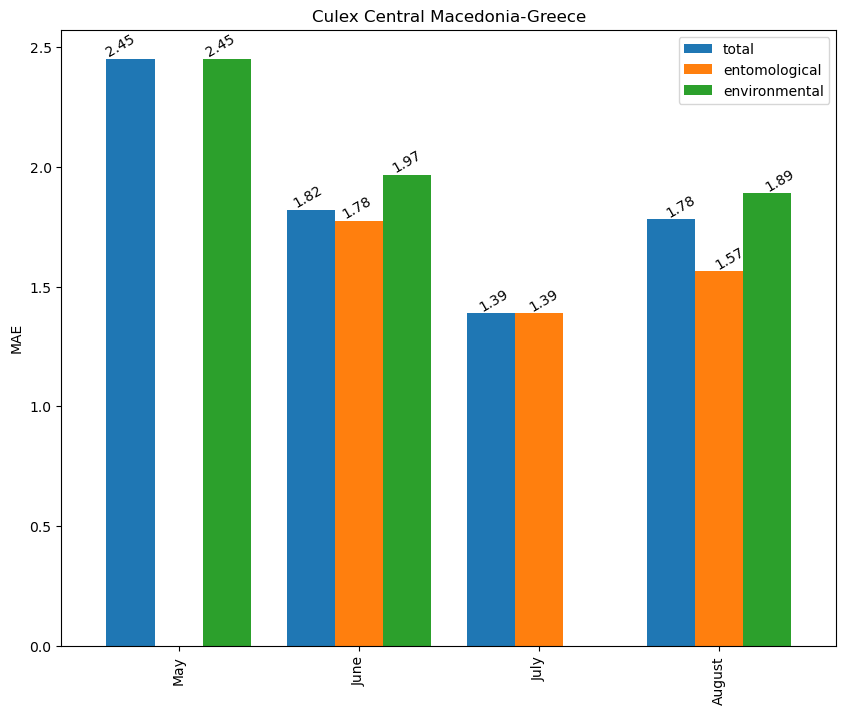

In [9]:
validate_results(predictions_path = '../predictions/Greece/Central Macedonia/',
                 data_path = '../../Datasets/Greece/GR_2011_2022.csv',
                 bounds = [0., 5., 14., 28., 50., 85., 144., 238., 405.6, 754., 10458.],
                 mosq_col = 'culex spp.', case = 'Culex Central Macedonia-Greece', region = 'CENTRAL MACEDONIA', period = 10)

Mean time difference in days: -2.8214285714285716
-------------------
Overall MAE: 2.642857142857143
Overall % error < 3: 71.43
-------------------
MAE with entomological: 2.5254237288135593
% error < 3 with entomological: 71.19
-------------------
MAE without entomological: 2.92
% error < 3 without entomological: 72.0
-------------------
number of observations: 84


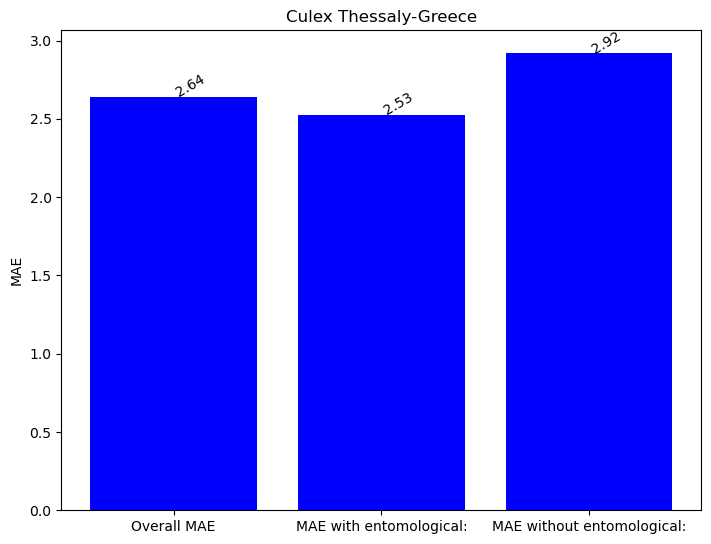

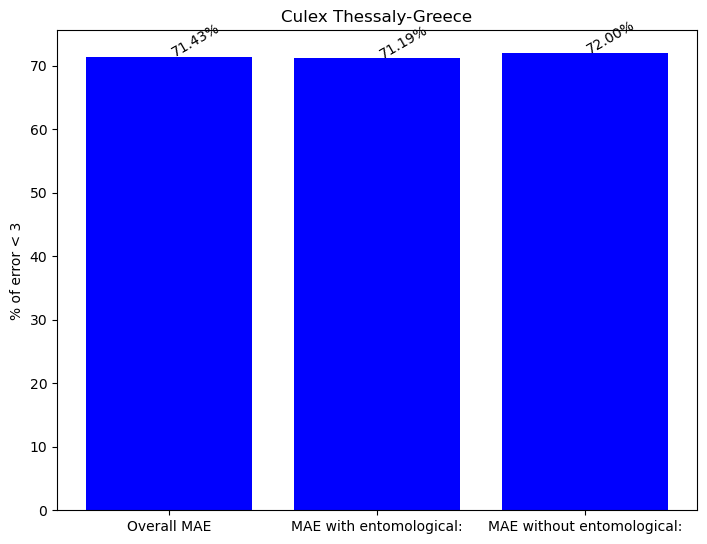

month 5 : 21
month 5: 2.9523809523809526
month 6 : 17
month 6: 2.7058823529411766
month 7 : 26
month 7: 2.769230769230769
month 8 : 20
month 8: 2.1


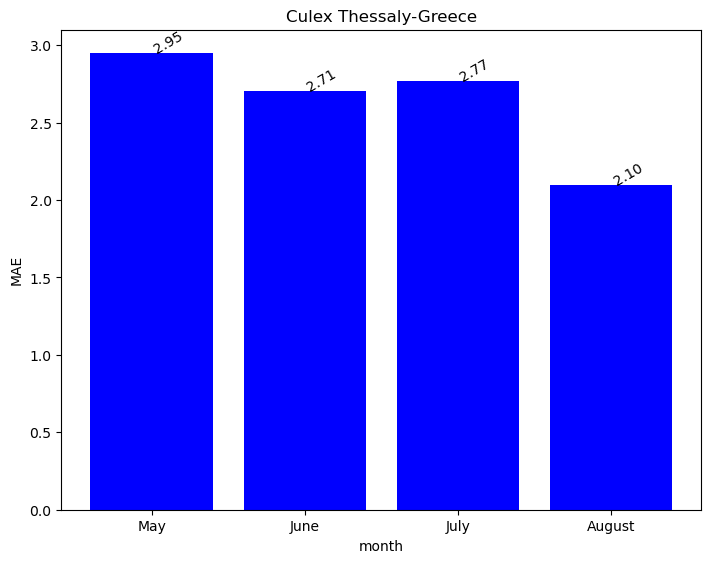

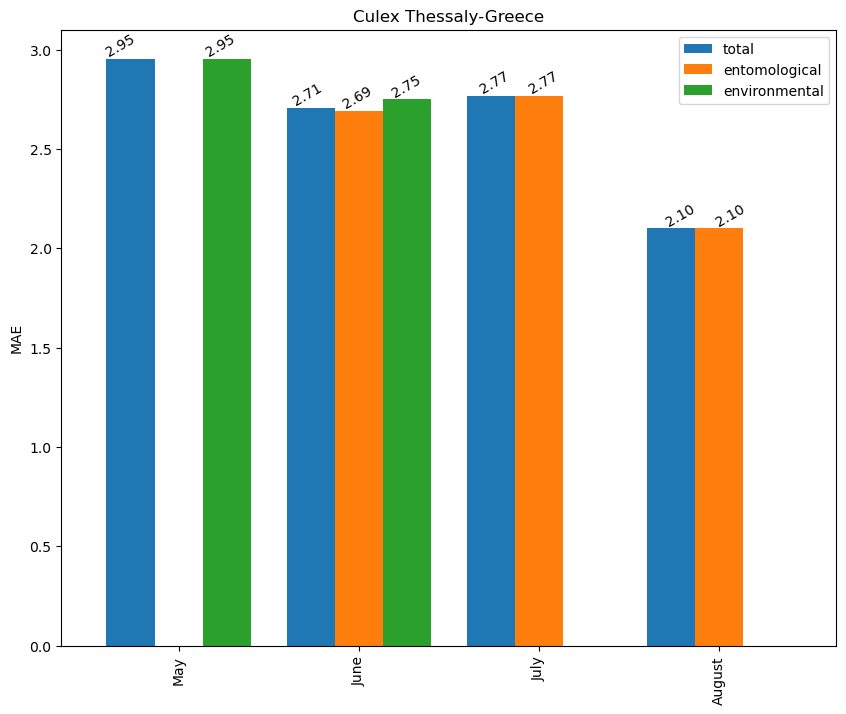

In [10]:
validate_results(predictions_path = '../predictions/Greece/Thessaly/',
                 data_path = '../../Datasets/Greece/GR_2011_2022.csv',
                 bounds = [-1, 0, 1., 3., 5.77777778, 10. , 18., 30., 45.33333333, 80.22222222, 164., 1652.],
                 mosq_col = 'culex spp.', case = 'Culex Thessaly-Greece', region = 'THESSALY', period = 10)

Mean time difference in days: -1.9666666666666666
-------------------
Overall MAE: 1.1666666666666667
Overall % error < 3: 96.67
-------------------
MAE with entomological: 0.9166666666666666
% error < 3 with entomological: 100.0
-------------------
MAE without entomological: 1.3333333333333333
% error < 3 without entomological: 94.44
-------------------
number of observations: 60


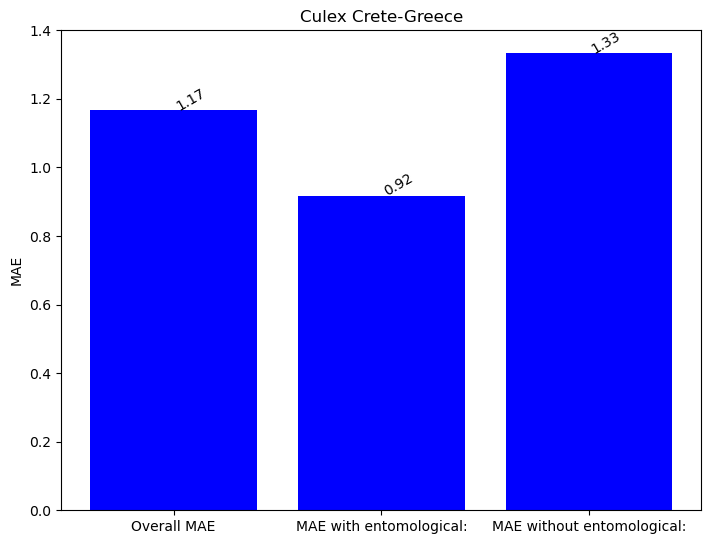

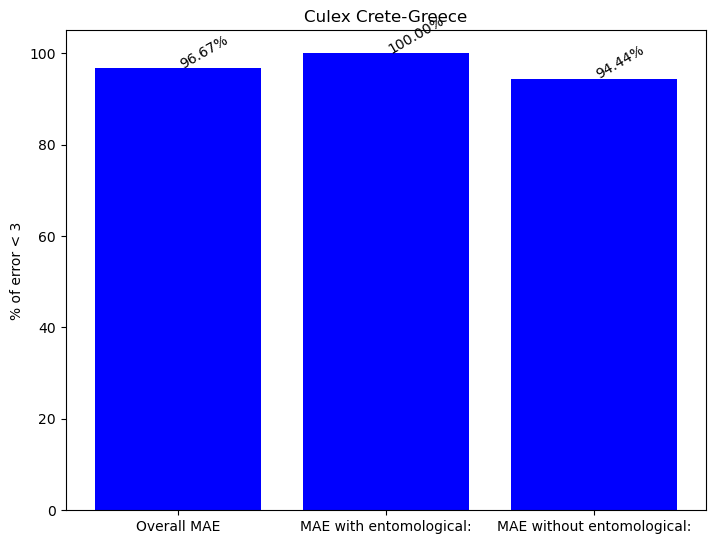

month 5 : 20
month 5: 1.35
month 6 : 22
month 6: 1.2727272727272727
month 7 : 9
month 7: 0.6666666666666666
month 8 : 9
month 8: 1.0


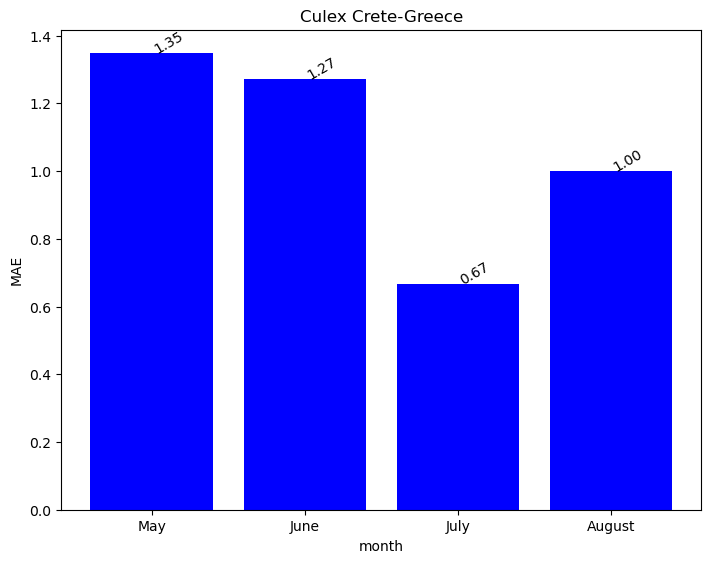

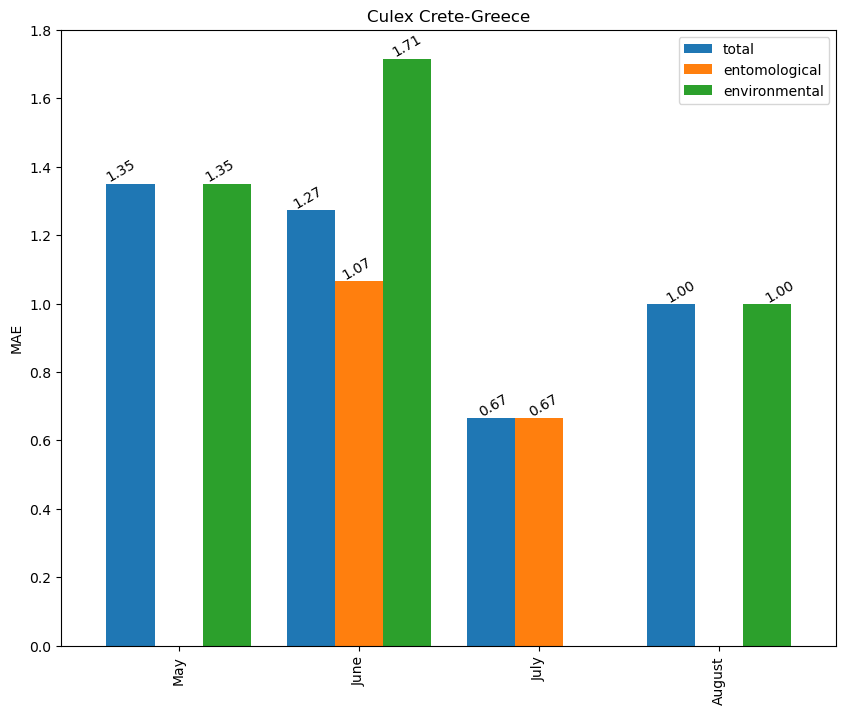

In [11]:
validate_results(predictions_path = '../predictions/Greece/Crete/',
                 data_path = '../../Datasets/Greece/GR_2011_2022.csv',
                 bounds = [-1,   0.,  1.,  2.,  3., 6., 14., 27., 35., 50., np.inf],
                 mosq_col = 'culex spp.', case = 'Culex Crete-Greece', region = 'CRETE', period = 10)

Mean time difference in days: 0.61
-------------------
Overall MAE: 2.57
Overall % error < 3: 79.0
-------------------
MAE with entomological: 2.3733333333333335
% error < 3 with entomological: 85.33
-------------------
MAE without entomological: 3.16
% error < 3 without entomological: 60.0
-------------------
number of observations: 100


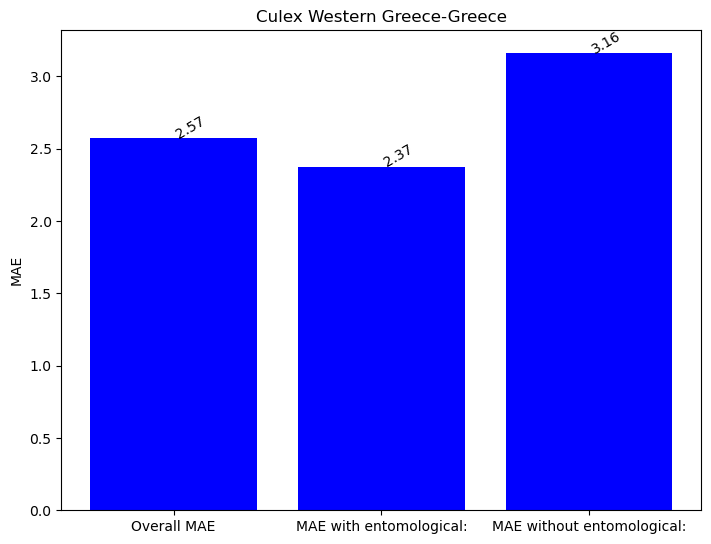

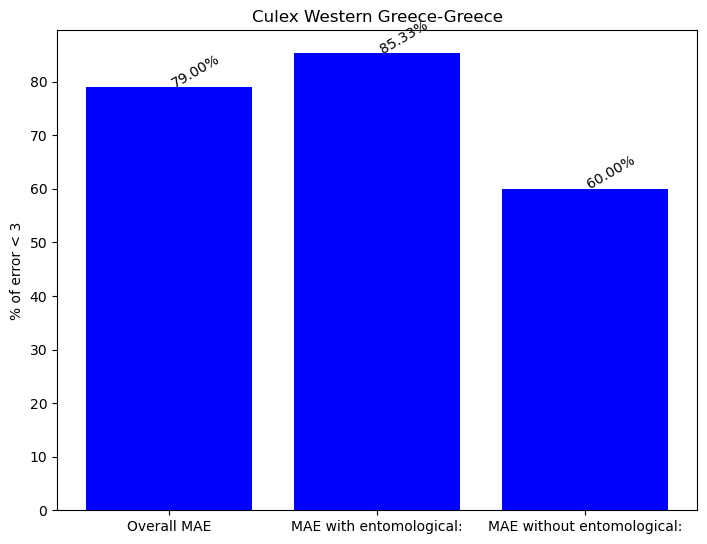

month 5 : 25
month 5: 3.16
month 6 : 44
month 6: 2.477272727272727
month 7 : 30
month 7: 2.2
month 8 : 1
month 8: 3.0


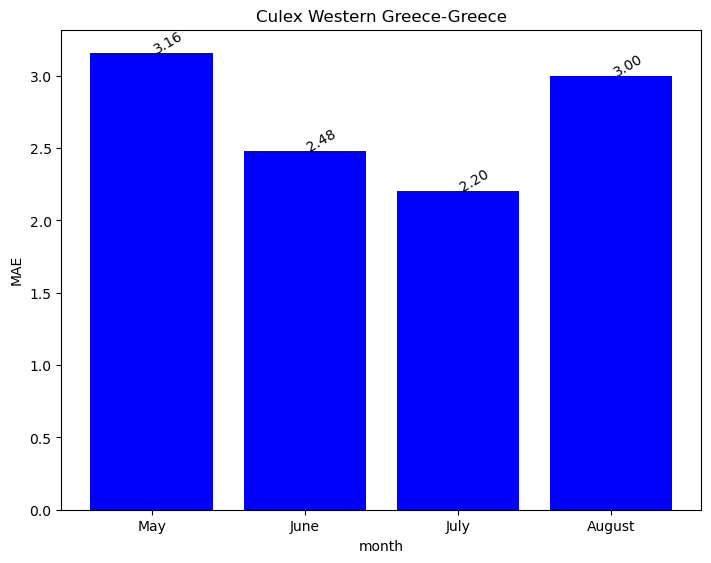

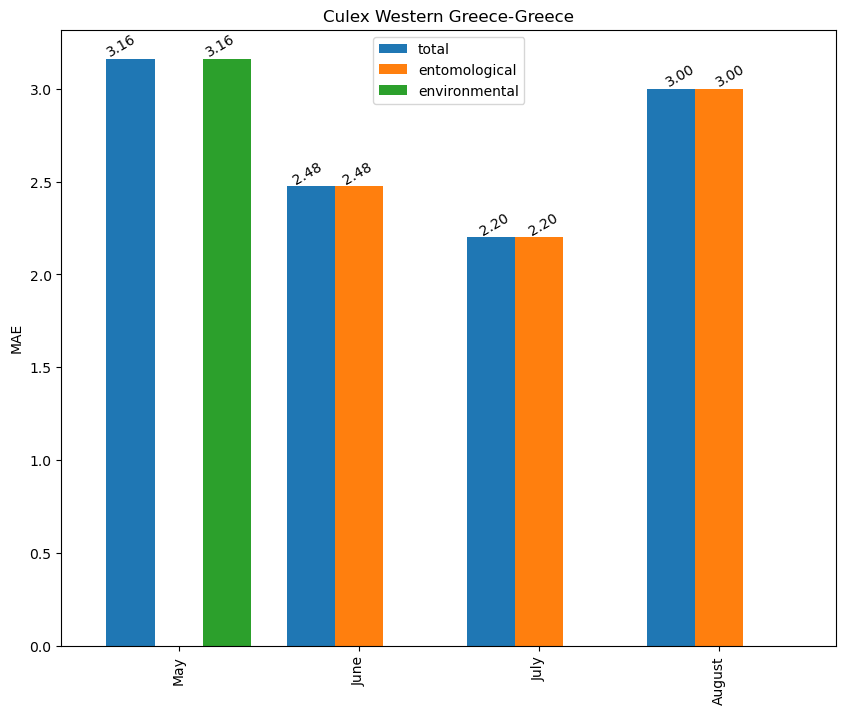

In [12]:
validate_results(predictions_path = '../predictions/Greece/Western Greece/',
                 data_path = '../../Datasets/Greece/GR_2011_2022.csv',
                 bounds = [-1, 0, 1., 2., 4.44444444, 7., 12., 18., 27., 41., 74., 2973.],
                 mosq_col = 'culex spp.', case = 'Culex Western Greece-Greece', region = 'WESTERN GREECE', period = 10)

Mean time difference in days: -0.6164383561643836
-------------------
Overall MAE: 0.9315068493150684
Overall % error < 3: 93.15
-------------------
MAE with entomological: 1.0
% error < 3 with entomological: 92.19
-------------------
MAE without entomological: 0.4444444444444444
% error < 3 without entomological: 100.0
-------------------
number of observations: 73


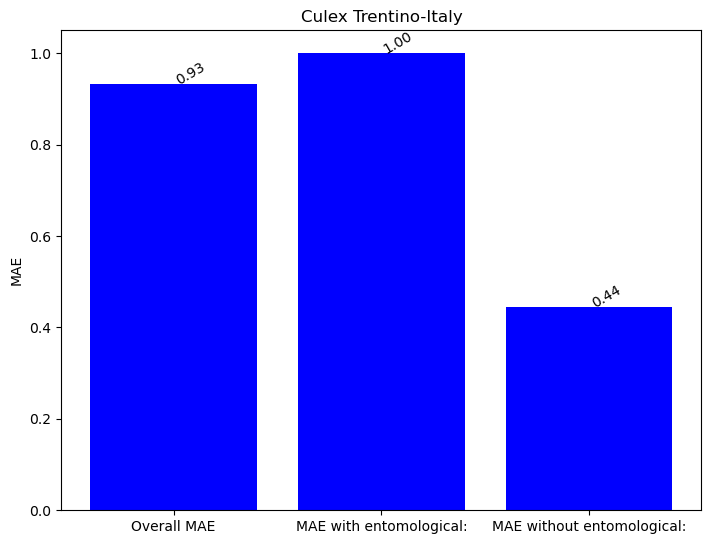

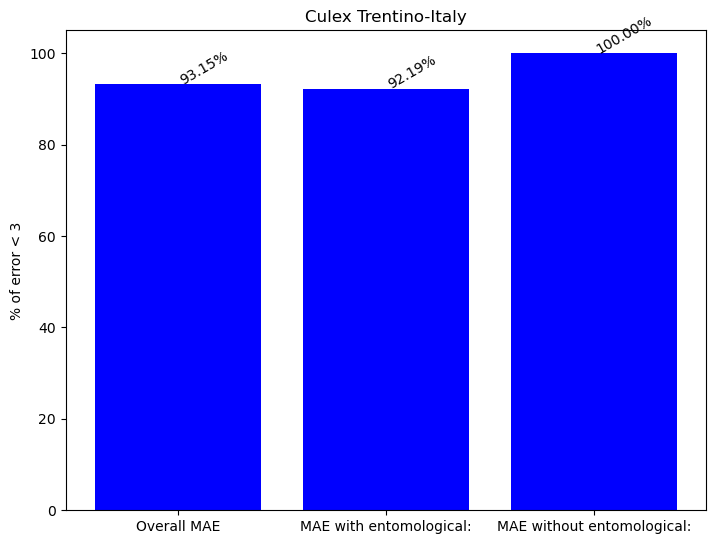

month 5 : 9
month 5: 0.4444444444444444
month 6 : 13
month 6: 1.3846153846153846
month 7 : 27
month 7: 1.037037037037037
month 8 : 8
month 8: 0.875
month 9 : 16
month 9: 0.6875


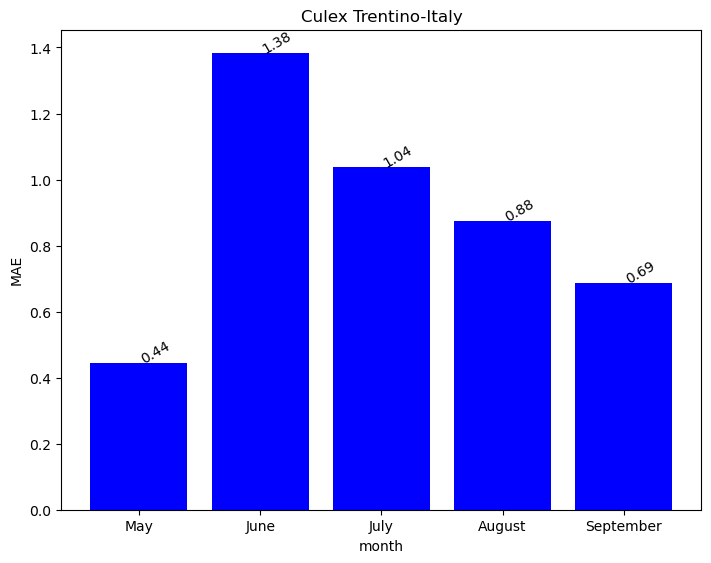

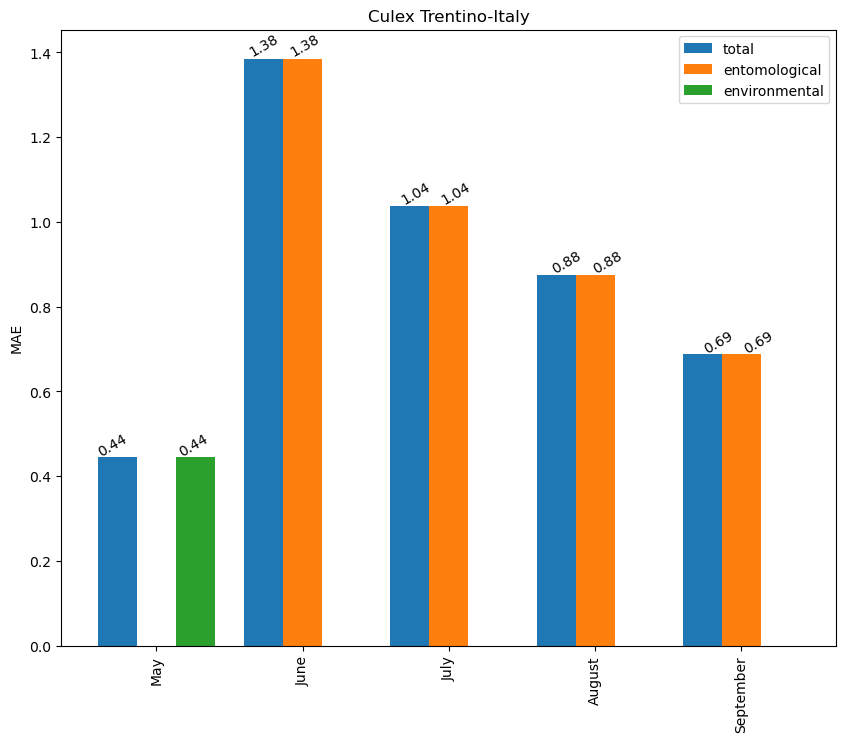

In [13]:
validate_results(predictions_path = '../predictions/Italy/Trentino/Culex/',
                 data_path = '../../Datasets/Italy/Trentino/Culex/IT_trentino_culex_2011_2022.csv',
                 bounds = [-1, 1., 2., 3., 5., 8., 11., 14., 23., 30., np.inf],
                 mosq_col = 'culex spp.',case = 'Culex Trentino-Italy',
                 dupl_list = ['x','y','dt_placement','sex'], period = 10)

Mean time difference in days: -0.574468085106383
-------------------
Overall MAE: 0.06382978723404255
Overall % error < 3: 100.0
-------------------
MAE with entomological: 0.0
% error < 3 with entomological: 100.0
-------------------
MAE without entomological: 0.3333333333333333
% error < 3 without entomological: 100.0
-------------------
number of observations: 47


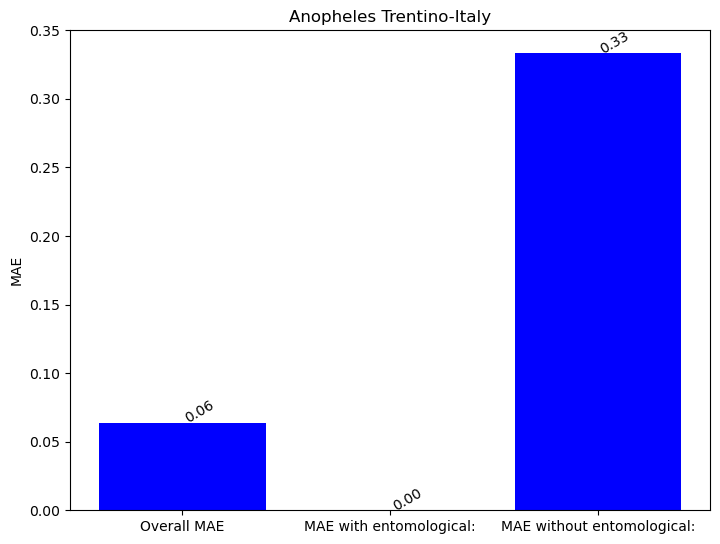

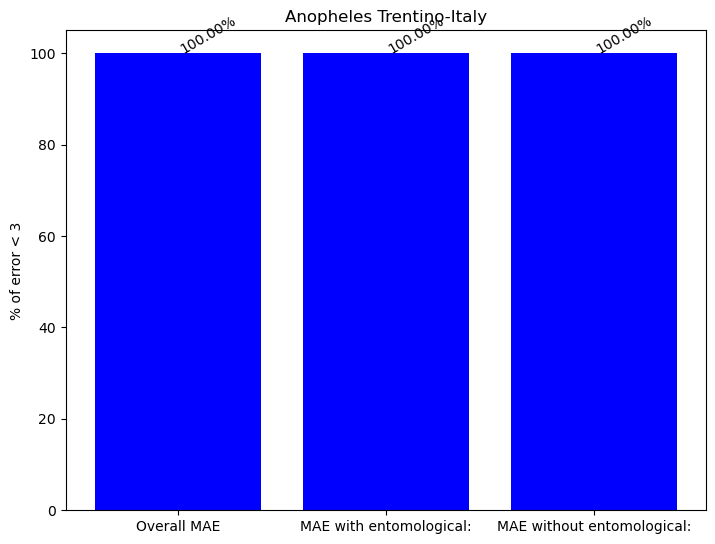

month 5 : 9
month 5: 0.3333333333333333
month 6 : 7
month 6: 0.0
month 7 : 15
month 7: 0.0
month 8 : 7
month 8: 0.0
month 9 : 9
month 9: 0.0


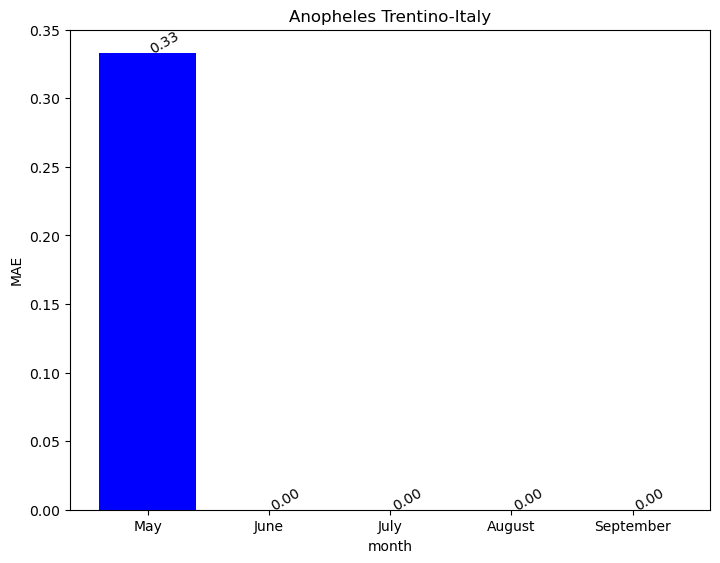

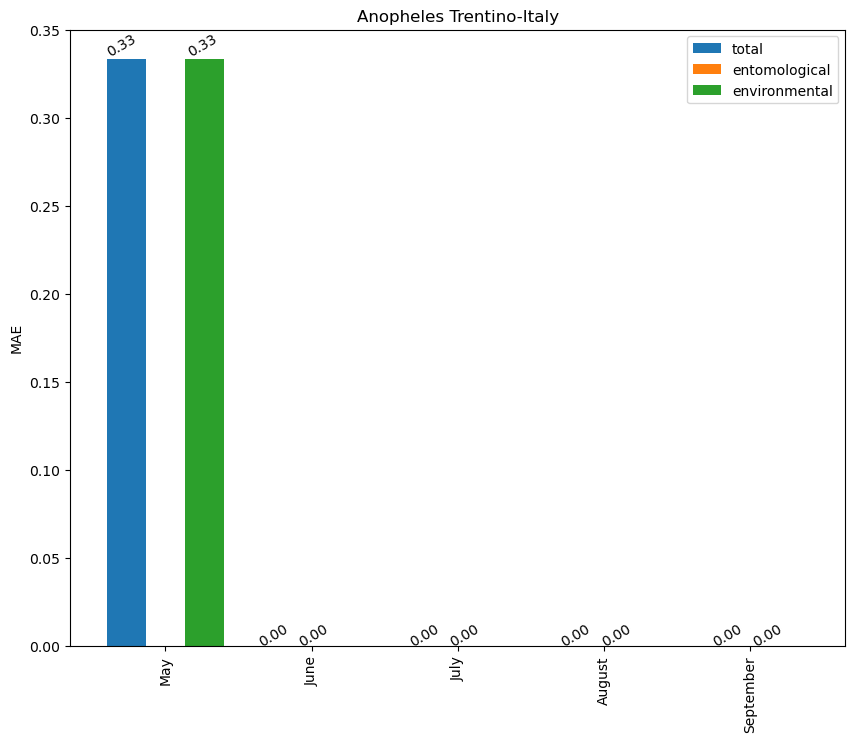

In [14]:
validate_results(predictions_path = '../predictions/Italy/Trentino/Anopheles/',
                 data_path = '../../Datasets/Italy/Trentino/Anopheles/IT_trentino_anopheles_2011_2022.csv',
                 bounds = [-1, 1., 2., 3., 5., 8., 11., 14., 23., 40., np.inf],
                 mosq_col = 'anopheles_total',case = 'Anopheles Trentino-Italy',
                 dupl_list = ['x','y','dt_placement','sex'], period = 10)

Mean time difference in days: -0.6811594202898551
-------------------
Overall MAE: 2.463768115942029
Overall % error < 3: 78.26
-------------------
MAE with entomological: 2.3833333333333333
% error < 3 with entomological: 81.67
-------------------
MAE without entomological: 3.0
% error < 3 without entomological: 55.56
-------------------
number of observations: 69


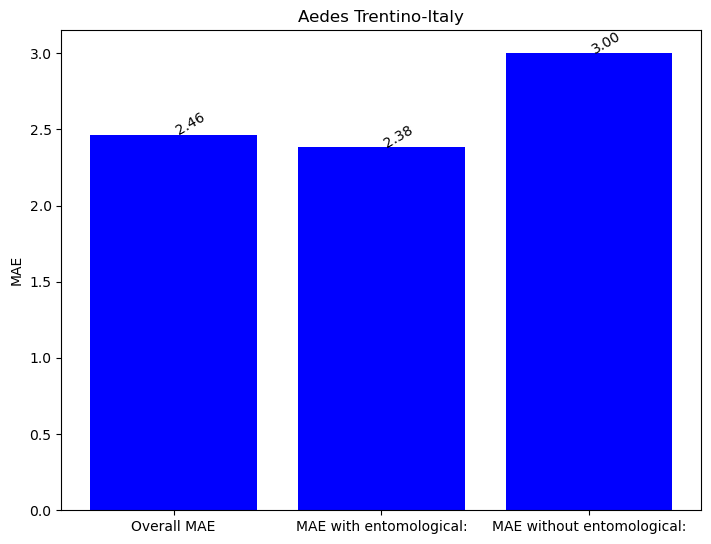

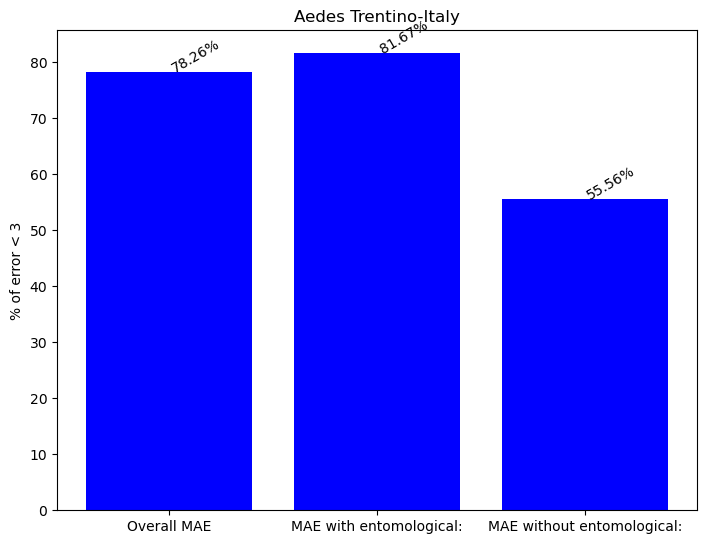

month 5 : 9
month 5: 3.0
month 6 : 13
month 6: 2.3846153846153846
month 7 : 25
month 7: 2.12
month 8 : 9
month 8: 2.111111111111111
month 9 : 13
month 9: 3.076923076923077


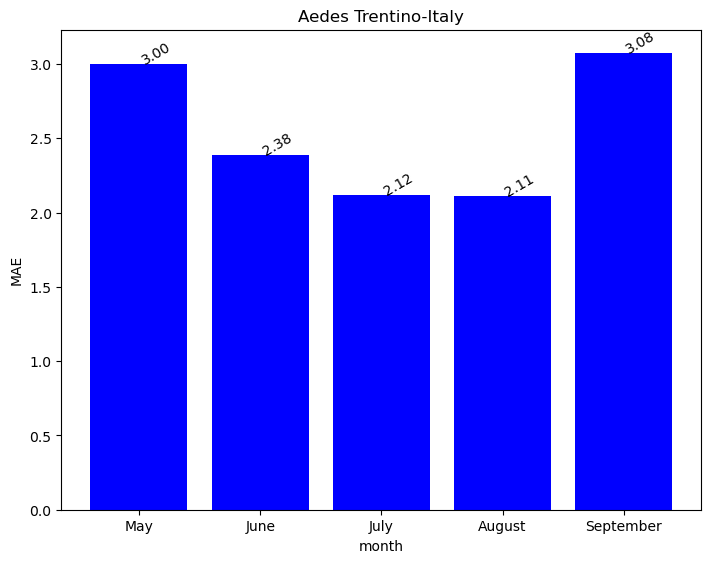

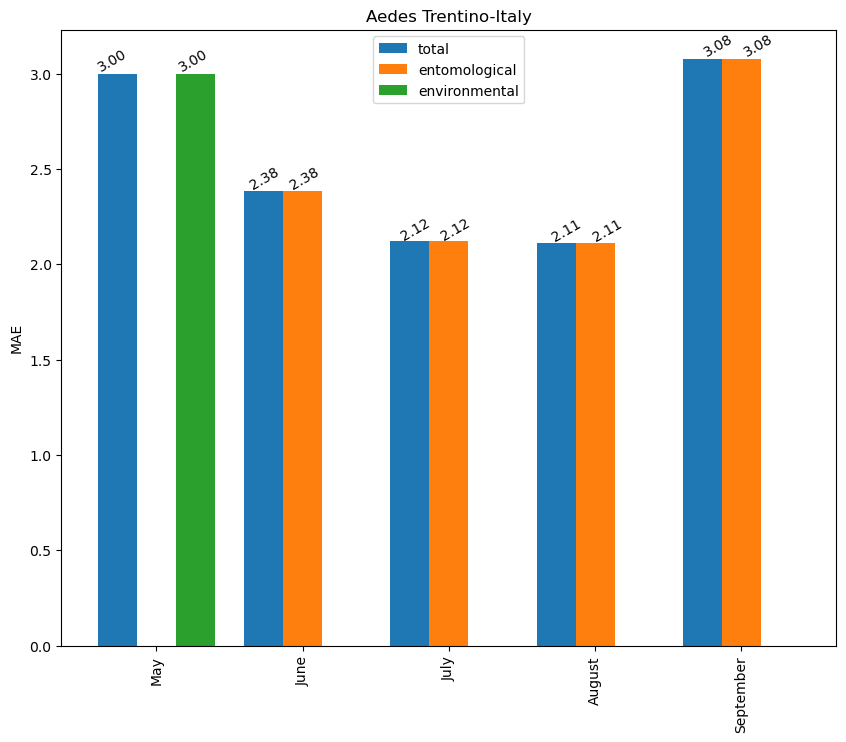

In [15]:
validate_results(predictions_path = '../predictions/Italy/Trentino/Aedes/',
                 data_path = '../../Datasets/Italy/Trentino/Aedes/IT_trentino_aedes_2011_2022.csv',
                 bounds = [-1, 1., 2., 3., 5., 8., 11., 14., 23., 40., np.inf],
                 mosq_col = 'aedes albopictus',case = 'Aedes Trentino-Italy',
                 dupl_list = ['x','y','dt_placement','sex'], period = 10)